#  Machine Learning for Pair Recognition across NASDAQ and Mean-Reversion strategy

<br />
Borghol Nicolas, March 2018

This notebook will be the first part of a future series of attempts in using various machine learning technics and applying my findings to the financial field through algorithmic trading.<br />

In this part, I will firstly focus on finding eligible pairs listed on the NASDAQ to trade on a mean-reversion strategy and then test a sample of those pairs using real data and functional algorithm on Quantopian. Most of the following algorithmic work is based on the book **"Algorithmic Trading Winning Strategies and Their Rationale"**wrote by Ernie Chan and adapted in python.


This provided algorithm will serve me as a learning process and will be further developed and improved throughout my journey.

http://images.globes.co.il/images/NewGlobes/big_image_800/2015/800(2).jpg




#1.Mean Reversion and Pair Trading 101

### What is mean-reversion?

<p>To make it simple, Mean reversion trading looks to capitalize on extreme changes within the pricing of a particular security, based on the assumption that it will revert to a hypothetical mean.</p> 
<p>However, unlike returns, the vast majority of **price series are not mean reverting, but act more like geometric random walks.**</p>


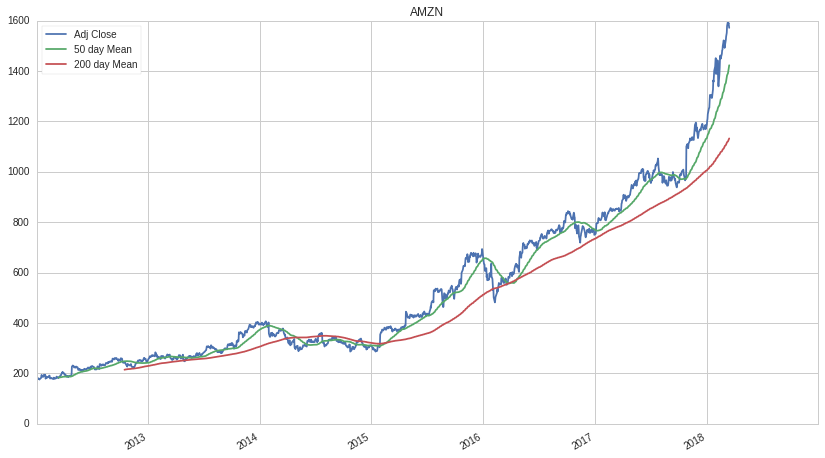

In [52]:
# Import the needed libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from pykalman import KalmanFilter
from scipy import poly1d
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from scipy import stats
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.filters.morningstar import Q1500US
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
start = '2012-01-01'
end = '2018-12-31'
x = get_pricing('AMZN', fields='price', start_date=start, end_date=end)
x.name = 'Adj Close'
amzn_50ma = x.rolling(window=50, center=False).mean()
amzn_50ma.name = '50 day Mean'
amzn_200ma = x.rolling(window=200, center=False).mean()
amzn_200ma.name = '200 day Mean'
x.plot(title='AMZN', legend=True);amzn_50ma.plot(legend=True);amzn_200ma.plot(legend=True);


From the graph of AMAZON, we can see that the price often goes up and down and up and down but has a sharpe upward trend over the last few years, shifting the mean price every time indicating that AMAZON is not stationary or mean reverting.

### Pairs and Cointegration 

<p>Fortunately, we can create a portfolio two or more individual securities so this newly portfolio is stationary. This is the notion of cointegration between securities. (ie: When there is some linear combination between the assets so that the distance between the pair prices doesn’t change drastically over time)</p> 
*For more information, visit <a href="https://www.quantopian.com/lectures/integration-cointegration-and-stationarity" title="link to google">Integration, Cointegration, and Stationarity</a> lecture on Quantopian*


<p>At minimum, one woul takes two unique securities, determines whether they are cointegrated and correlated, and then makes trades when one of the securities doesn’t follow the movements of the other by **going long one** and **short the other** when the pair's price ratio diverges too much from its mean.</p>

<p>When the pair  reverts to its mean trend, the trade is exited and a profit is made on one or both of the positions.</p>

<p>For example, **Huntington Bancshares** and **East West Bancorp**, two stocks prevailing in the same industry seem likely cointegrated.
A scatter plot of HBAN versus EWBC is even more convincing as the price pairs nearly fall on a straight line.<p>


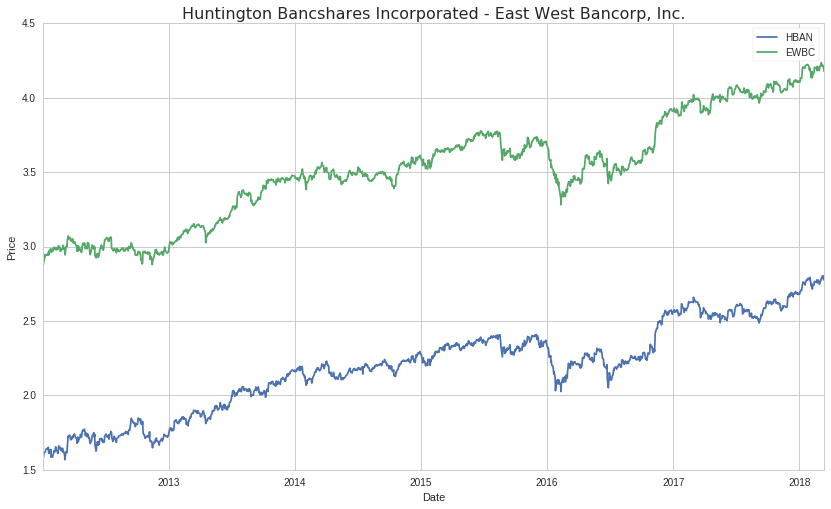

In [34]:
# Load pricing data
start = '2012-01-01'
end = '2018-03-15'
x = get_pricing('HBAN', fields='price', start_date=start, end_date=end)
y = get_pricing('EWBC', fields='price', start_date=start, end_date=end)
# Plog the stock prices on a logarithmic scale
plt.plot(np.log(x))
plt.plot(np.log(y))
plt.title('Huntington Bancshares Incorporated - East West Bancorp, Inc.',
         fontname="Times New Roman Bold", fontsize=16)
plt.legend(['HBAN', 'EWBC'])
plt.xlabel('Date')
plt.ylabel('Price');

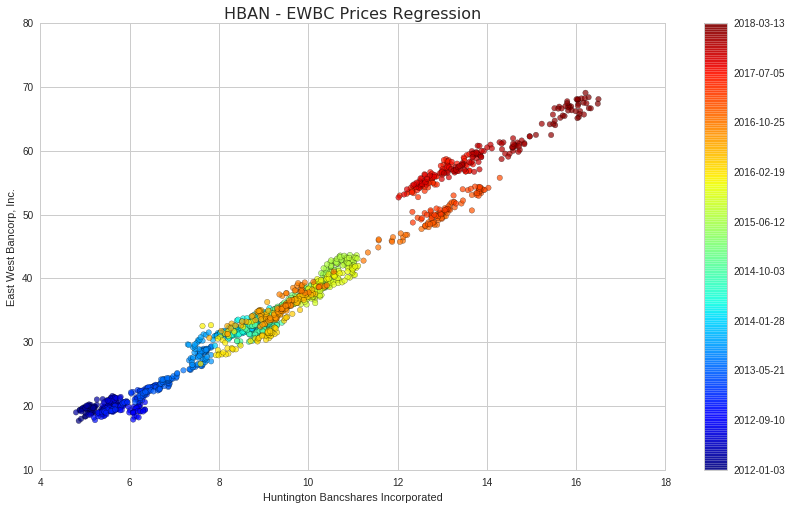

In [35]:
# Plot data and use colormap to indicate the date each point corresponds to
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, len(x))
sc = plt.scatter(x, y, s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in x[::len(x)//9].index])
plt.title('HBAN - EWBC Prices Regression',
         fontname="Times New Roman Bold", fontsize=16)
plt.xlabel('Huntington Bancshares Incorporated')
plt.ylabel('East West Bancorp, Inc.');


One way to deal with the rareness of mean reverting stock is to construct a new synthetic price series by combining linearly two securities which are non-stationnary.

This newly created price series Z would take this form: 

$Z = Y - (\alpha + \beta X)$

To construct and try this pair for stationnarity, the **Covariate Augmented Dickey Fuller Test (CADF)**is used. The principle of the test is quiet simple. First, the two stocks are regressed one against the other to determine the portfolio’s **optimal hedge ratio** and then a normal **Augmented Dickey Fuller (ADF)** test is applied to test for stationarity of the new price series.

The augmented Dickey-Fuller statistic used in the ADF test is a negative number, and the more negative it is, the stronger the rejection of the hypothesis that there is a unit root (ie: serie not stationary).

In [36]:
result = coint(x,y)
print('CADF Statistic: {:.3f}'.format(result[0]))
print('Critical Values at 95%: {:.3f}'.format(result[2][1]))
print('p-value: %f' % result[1])

CADF Statistic: -4.336
Critical Values at 95%: -2.863
p-value: 0.002248


**The Cointegration ADF** test would test the **null hypothesis of no cointegration** between the time series pairs.<br/>
The resulting test statistic is about -4.36, more negative than the critical value at the 95 percent level of confidence of -2.86.<br/> Therefore, We can reject the null hypothesis. In other words, **HBAN and EWBC
are likely to be cointegrated** on the regression period.

To better visualize this newly portfolio the spread of the two series, let's plot it.

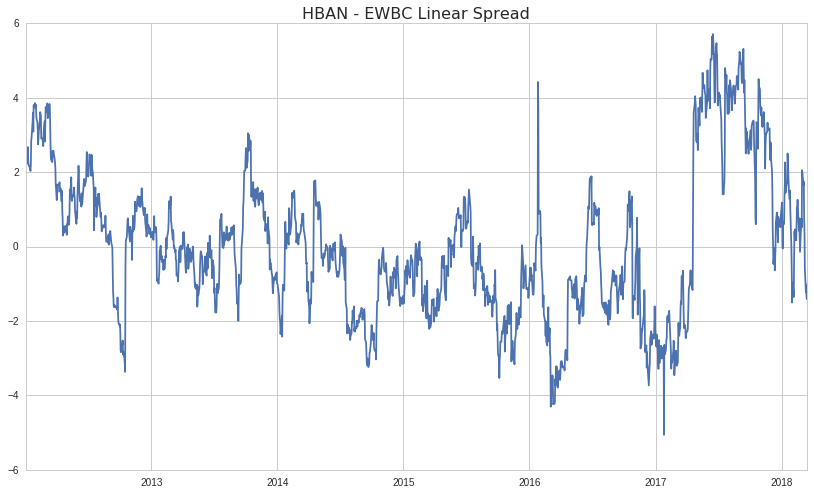

In [37]:
X = sm.add_constant(x)
model = sm.OLS(y,X)
results = model.fit()
Z = y - (results.params[0] + results.params[1]*x)
plt.plot(Z)
plt.title('HBAN - EWBC Linear Spread',
         fontname="Times New Roman Bold", fontsize=16);


### Kalman Filter 

Because a mean-reverting strategy relies on beta hedging, thinking that the alpha and beta parameters are constant over time would be very naive. Beta and other parameters are indeed evolving through time and market conditions. It become obvious that having the best and most current estimate of the beta is crucial for such a strategy.

Kalman filter is an answer to this problem. It's an optimal linear algorithm that updates the expected
value of a parameter based on the latest value of an observable variable whilst taking noise into account. With Kalman Filter β is now a dynamic parameter

To visualize how the parameters can evolve through time, different regression slopes at different time are plotted below. Notice how the slopes of regression are changing over time.

In [38]:
delta = 1e-3
trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=[0,0],
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=2,
                  transition_covariance=trans_cov)
# Use the observations y to get running estimates and errors for the state parameters
state_means, state_covs = kf.filter(y.values);

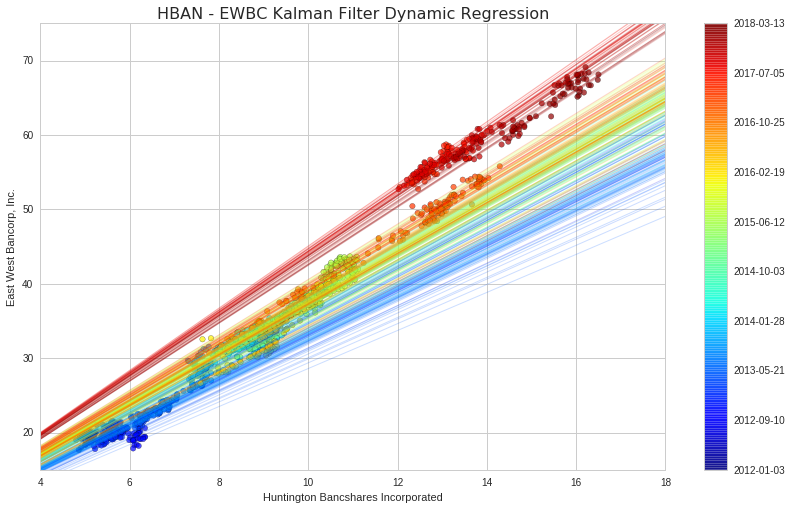

In [39]:
# Reference: http://www.thealgoengineer.com/2014/online_linear_regression_kalman_filter/

# Plot data points using colormap
sc = plt.scatter(x, y, s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in x[::len(x)//9].index])
# Plot every fifth line
step = 5
xi = np.linspace(x.min()-5, x.max()+5, 2)
colors_l = np.linspace(0.1, 1, len(state_means[::step]))
for i, beta in enumerate(state_means[::step]):
    plt.plot(xi, beta[0] * xi + beta[1], alpha=.2, lw=1, c=cm(colors_l[i]))   
# Adjust axes for visibility
plt.axis([4, 18, 15, 75])

plt.title('HBAN - EWBC Kalman Filter Dynamic Regression',
         fontname="Times New Roman Bold", fontsize=16)
plt.xlabel('Huntington Bancshares Incorporated')
plt.ylabel('East West Bancorp, Inc.');

### Spread with dynamic parameters
The precedent spread can now be updated according to our dynamic parameters alpha and beta. It appears way more revolving around a mean of 0 and much more mean reverting.

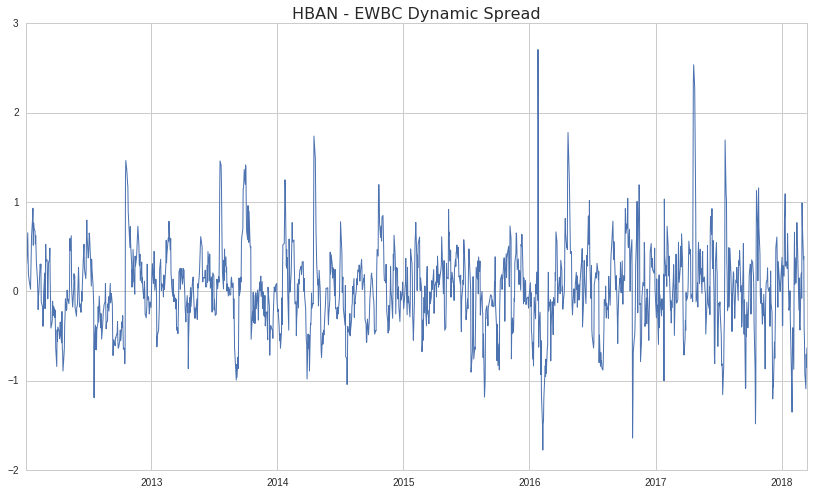

In [41]:
Z2 = y - (state_means[:, 1] + state_means[:, 0] * x)
plt.plot(Z2, linewidth=1)
plt.title('HBAN - EWBC Dynamic Spread',
         fontname="Times New Roman Bold", fontsize=16);

Running the stationnary test one more time on this newly dynamic portfolioindicates strong stationnarity and mean-reversing behaviour.

In [56]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(Z2)
print('ADF Statistic: {:.3f}'.format(result[0]))
print('Critical Values at 95%: {:.3f}'.format(result[4].values()[0]))
print('p-value: %f' % result[1])


ADF Statistic: -13.707
Critical Values at 95%: -2.863
p-value: 0.000000


#2. Quest to find strong eligible pairs

The following work is based on a notebook written by Jonathan Larkin on Quantopian and adapted to fit our expectation. It show how classic unsupervised clusturing Machine Learning algorithms can help to find eligible tradeable pairs.

In [4]:
# We adjust our model based on 2 years of data with end_date 2 years from now. 
#Giving us a 2 years out-of-sample to test our model and algorithm
in_sample_end_date = "2016-03-15"
# Defining the Quantopian universe of stock. 
# Q1500US is a large and liquid collection of stocks
universe = Q1500US()

In [5]:
pipe = Pipeline(
    columns= {
        'Market Cap': morningstar.valuation.market_cap.latest.quantiles(5),
        'Industry': morningstar.asset_classification.morningstar_industry_group_code.latest,
        'Financial Health': morningstar.asset_classification.financial_health_grade.latest,
        'Exchange': morningstar.share_class_reference.exchange_id.latest
    },
    screen=universe
)
res = run_pipeline(pipe, in_sample_end_date, in_sample_end_date)
res.index = res.index.droplevel(0)

In [33]:
# remove stocks in Industry "Conglomerates"
res = res[res['Industry']!=31055]
# remove stocks without a Financial Health grade
res = res[res['Financial Health']!= None]
# replace the categorical data with numerical scores per the docs
res['Financial Health'] = res['Financial Health'].astype('object')
health_dict = {u'A': 0.1,
               u'B': 0.3,
               u'C': 0.7,
               u'D': 0.9,
               u'F': 1.0}
res = res.replace({'Financial Health': health_dict})
# remove stocks without a Financial Health grade
res = res[res['Exchange'] == 'NAS']
res.shape

(494, 4)

In [32]:
pricing = get_pricing(
    symbols=res.index,
    fields='close_price',
    start_date=pd.Timestamp(in_sample_end_date) - pd.DateOffset(months=24),
    end_date=pd.Timestamp(in_sample_end_date)
)
pricing.shape

(504, 494)

In [37]:
# we can only work with stocks that have the full return series
returns = pricing.pct_change().iloc[1:,:].dropna(axis=1)
returns.shape

(503, 447)

In [43]:
# the initial dimensionality of the search is:
print "Total pairs possible in universe: %d " % (len(returns.columns)*(len(returns.columns)-1)/2)

Total pairs possible in universe: 99681 


In [38]:
N_PRIN_COMPONENTS = 50
pca = PCA(n_components=N_PRIN_COMPONENTS)
pca.fit(returns)

PCA(copy=True, n_components=50, whiten=False)

In [39]:
X = np.hstack(
    (pca.components_.T,
     res['Market Cap'][returns.columns].values[:, np.newaxis],
     res['Financial Health'][returns.columns].values[:, np.newaxis])
)
X.shape

(447, 52)

In [50]:
X = preprocessing.StandardScaler().fit_transform(X)
clf = DBSCAN(eps=1.9, min_samples=3)
clf.fit(X)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
clustered = clf.labels_
clustered_series = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series_all = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print "Clusters formed: %d" % len(ticker_count_reduced)
print "Number of stock selected: %d" % ticker_count_reduced.sum()
print "Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum()

Clusters formed: 3
Number of stock selected: 36
Pairs to evaluate: 500


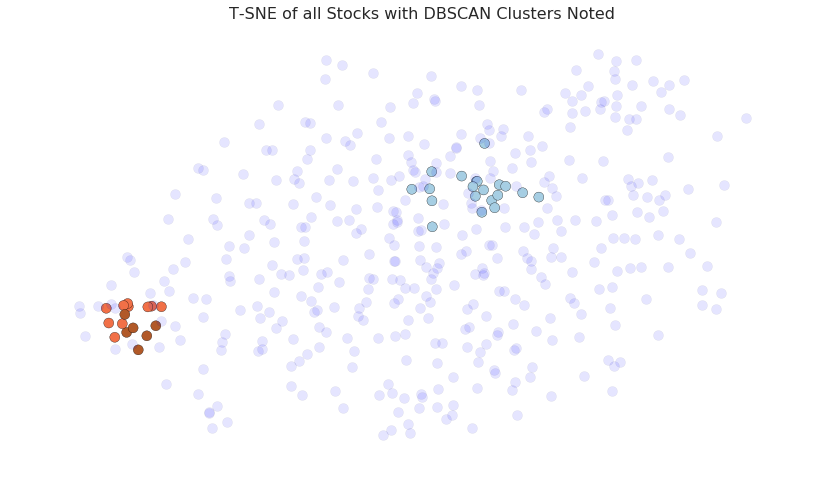

In [67]:
X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X)
plt.figure(1, facecolor='white')
plt.clf()
plt.axis('off')
plt.scatter(
    X_tsne[(labels!=-1), 0],
    X_tsne[(labels!=-1), 1],
    s=100,
    alpha=1,
    c=labels[labels!=-1],
    cmap=cm.Paired
)
plt.scatter(
    X_tsne[(clustered_series_all==-1).values, 0],
    X_tsne[(clustered_series_all==-1).values, 1],
    s=100,
    alpha=0.1
)
plt.title('T-SNE of all Stocks with DBSCAN Clusters Noted',
         fontname="Times New Roman Bold", fontsize=16);

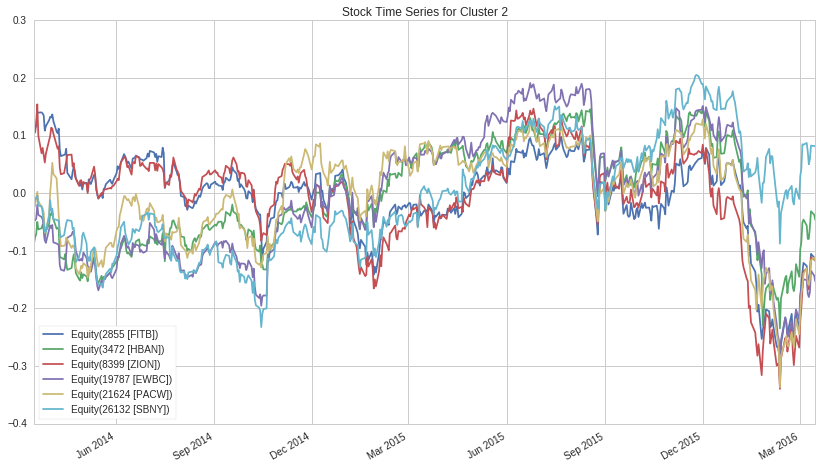

In [75]:
# let's visualize a cluster
cluster_vis_list = list(counts[(counts<20) & (counts>1)].index)[::-1]

tickers = list(clustered_series[clustered_series==2].index)
means = np.log(pricing[tickers].mean())
data = np.log(pricing[tickers]).sub(means)
data.plot(title='Stock Time Series for Cluster %d' % 2);

In [55]:
def find_cointegrated_pairs(data, significance=0.05):
    # This function is from https://www.quantopian.com/lectures/introduction-to-pairs-trading
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [56]:
cluster_dict = {}
for i, which_clust in enumerate(ticker_count_reduced.index):
    tickers = clustered_series[clustered_series == which_clust].index
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
        pricing[tickers]
    )
    cluster_dict[which_clust] = {}
    cluster_dict[which_clust]['score_matrix'] = score_matrix
    cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[which_clust]['pairs'] = pairs

In [57]:
pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])

In [59]:
print "We found %d pairs." % len(pairs)
print "In those pairs, there are %d unique tickers." % len(np.unique(pairs))

We found 13 pairs.
In those pairs, there are 16 unique tickers.


In [85]:
# Let's print 5 random cointegrated pairs that we found previously
for _ in range(5):
    print(pairs[np.random.randint(0, len(pairs))])

(Equity(1941 [CTAS]), Equity(11901 [SIRI]))
(Equity(15071 [ANSS]), Equity(18875 [DOX]))
(Equity(8162 [WAFD]), Equity(17264 [OZRK]))
(Equity(2855 [FITB]), Equity(8399 [ZION]))
(Equity(3472 [HBAN]), Equity(19787 [EWBC]))


## Quantopian Backtest on a pairs sample